Reference paper: [Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Jauvin. 2003. A Neural Probabilistic Language Model. J. Mach. Learn. Res. 3, (February 2003), 1137–1155.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

One main difference in our implementation is that we are working with characters instead of words. The vocabulary size in the Bengio's paper is 17,000 words, whereas we are going to have a vocabulary of 27 characters (26 characters and the `<.>` special character).

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
words = open("./names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set("".join(words))))
s2i = {s: i + 1 for i, s in enumerate(chars)}
s2i["."] = 0
i2s = {i: s for s, i in s2i.items()}
print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words):
    block_size = 3  # context length
    x, y = [], []
    for w in words:
#         print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = s2i[ch]
            x.append(context)
            y.append(ix)
#             print("".join(i2s[i] for i in context), "--->", i2s[ix])
            context = context[1:] + [ix]  # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    return x, y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_trn, y_trn = build_dataset(words[:n1])
x_val, y_val = build_dataset(words[n1:n2])
x_tst, y_tst = build_dataset(words[n2:])

In [6]:
for name, x_df, y_df in (("train", x_trn, y_trn), ("val", x_val, y_val), ("test", x_tst, y_tst)):
    print(f"{name} shape: \t{x_df.shape}, \t{y_df.shape}")

train shape: 	torch.Size([182625, 3]), 	torch.Size([182625])
val shape: 	torch.Size([22655, 3]), 	torch.Size([22655])
test shape: 	torch.Size([22866, 3]), 	torch.Size([22866])


In [7]:
C = torch.randn((27, 2))  # embeddig matrix

In [8]:
emb = C[x_trn]
emb.shape  # bs, ctx len, emb lengh

torch.Size([182625, 3, 2])

In [9]:
W1 = torch.randn((6, 100))  # (ctx len x emb length), hidden layer dim
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
h

tensor([[ 0.9715, -0.4301, -0.9945,  ...,  0.9180, -0.9999,  0.3096],
        [ 0.9956,  0.9833, -0.9254,  ...,  0.9862,  0.1666,  0.9755],
        [ 0.9362, -0.0168, -0.6430,  ...,  0.6051, -0.9334,  0.3653],
        ...,
        [ 0.3072,  0.3908, -0.4934,  ..., -0.2911, -0.8015,  0.8227],
        [ 0.9788,  0.8530, -0.3903,  ...,  0.5042,  0.2925,  0.6730],
        [ 0.9998, -0.8427, -0.9782,  ...,  0.9025, -0.9999, -0.8291]])

In [11]:
h.shape

torch.Size([182625, 100])

One thing to pay attention to, is the addition operation. The resulting matrix generated by multiplying `emb` (reshaped) and `W1` is of size `(32, 100)`, whilst the bias vector has size `(100)`.

```
32, 100 --> 32, 100
    100 -->  1, 100
```

So the same bias vector will be copied to all the rows of the (`emb.view(emb.shape[0], -1) @ W1`) matrix. Meaning that element `b[0, 0]` will be added to each element of the row `x[0, :]`.

In [12]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [13]:
logits = h @ W2 + b2

In [14]:
logits.shape

torch.Size([182625, 27])

In [15]:
counts = logits.exp()

In [16]:
probs = counts / counts.sum(1, keepdims=True)

In [17]:
probs.shape

torch.Size([182625, 27])

In [18]:
# sanity check, rows should sum to 1
probs[0].sum()

tensor(1.0000)

In [19]:
loss = -probs[torch.arange(x_trn.shape[0]), y_trn].log().mean()  # average neg log likelihood
loss

tensor(16.9105)

Let's rewrite all of the above in a more reusable way, and train the MLP model

How can we find a good startint point for the learning rate?

In [20]:
lre = []
lrs = []
tracker = []
steps = 1_000

for e in torch.linspace(-3, 0, steps):
    lrs.append(10**e)
    lre.append(e)
    
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g).requires_grad_()
W1 = torch.randn((6, 100), generator=g).requires_grad_()
b1 = torch.randn((100), generator=g).requires_grad_()
W2 = torch.randn((100, 27), generator=g).requires_grad_()
b2 = torch.randn((27), generator=g).requires_grad_()
parameters = [C, W1, b1, W2, b2]
bs = 32

for step in range(steps):
    # minibatch
    ix = torch.randint(0, x_trn.shape[0], (bs,))
    xs = x_trn[ix]
    ys = y_trn[ix]
    lr = lrs[step]

    # forward pass
    emb = C[xs]  # (32, 3, 2)
    h = torch.tanh(
        emb.view((-1, 6)) @ W1 + b1
    )  # (32, 100)... also tanh is important to not get inf loss!
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, ys)

#     if step % 10 == 0:
#         print(f"step {step}: {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    tracker.append(loss.item())

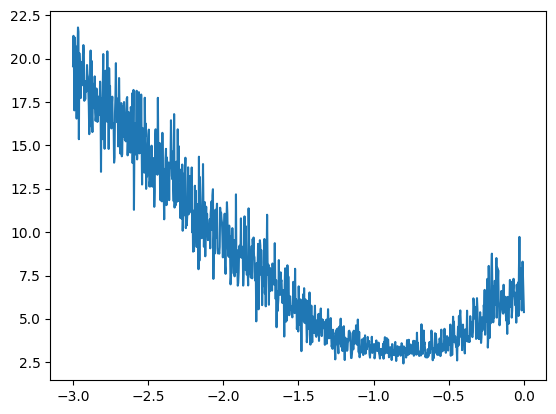

In [21]:
plt.plot(lre, tracker)

Using the LR Finder first proposed by [Leslie Smith](https://arxiv.org/abs/1506.01186), $ 10^{-1} $ seems like a good starting point.

In [22]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g).requires_grad_()
W1 = torch.randn((30, 200), generator=g).requires_grad_()
b1 = torch.randn((200), generator=g).requires_grad_()
W2 = torch.randn((200, 27), generator=g).requires_grad_()
b2 = torch.randn((27), generator=g).requires_grad_()
parameters = [C, W1, b1, W2, b2]

In [23]:
sum(p.nelement() for p in parameters)

11897

In [24]:
bs = 32
lr = 0.1
n_steps = 200_000

steps = []
lrs = []
losses = []

for step in range(n_steps):
    # minibatch
    ix = torch.randint(0, x_trn.shape[0], (bs,))
    xs = x_trn[ix]
    ys = y_trn[ix]

    # forward pass
    emb = C[xs]  # (32, 3, 10)
    h = torch.tanh(
        emb.view((-1, 30)) @ W1 + b1
    )  # (32, 100)... also tanh is important to not get inf loss!
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, ys)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # step lr decay
    if step == 100_000:
        lr /= 10
        print(f"---> new lr: {lr}")
    
    # update    
    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad
        
    steps.append(step)
    lrs.append(lr)
    losses.append(loss.log10().item())

---> new lr: 0.01


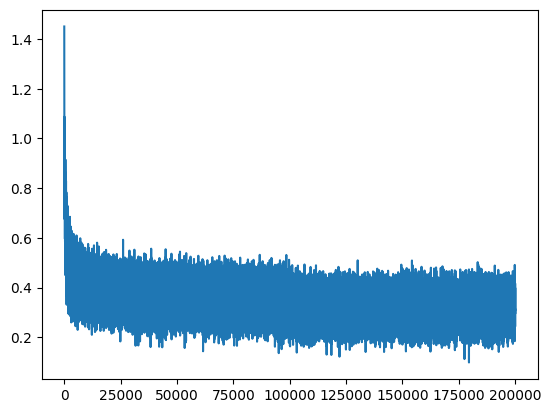

In [25]:
plt.plot(steps, losses)
ax = plt.gca()
plt.show()

In [26]:
emb = C[x_trn]  # (32, 3, 2)
h = torch.tanh(
    emb.view((-1, 30)) @ W1 + b1
)  # (32, 100)... also tanh is important to not get inf loss!
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_trn)
loss

tensor(2.1177, grad_fn=<NllLossBackward0>)

Let's validate the quality of our model on the validation set.

In [27]:
emb = C[x_val]  # (32, 3, 2)
h = torch.tanh(
    emb.view((-1, 30)) @ W1 + b1
)  # (32, 100)... also tanh is important to not get inf loss!
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.1649, grad_fn=<NllLossBackward0>)

In [28]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print("".join(i2s[i] for i in out))

mora.
mayah.
seel.
ndhoralarethan.
endraeg.
aderedieliigh.
parelle.
elieananarleigh.
malaia.
noshidvikahiriel.
kindreelle.
xethana.
usamyed.
ryyah.
faeha.
kayshaston.
azhia.
salynn.
unazalelle.
ren.


This generated names are better than those generated by the bigram model, although not that good yet.